In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

import re

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 41825352
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X = pd.read_csv('data/x.csv', index_col='date')
y = pd.read_csv('data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

### Tf-idf и линейная модель

Протестируем TF-IDF на текстах релизов.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf, y,
    LogisticRegression, 
    name='tf-idf l1 only release', 
    plot=False, 
    solver='liblinear', 
    penalty='l1', 
    C=c.item()
) for c in np.linspace(0.001, 100, 30))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=20.69044827586207, penalty='l1', solver='liblinear')
ROC-AUC = 0.7868333039957753


              precision    recall  f1-score   support

        -1.0       0.69      0.78      0.73        23
         0.0       0.54      0.54      0.54        26
         1.0       0.69      0.58      0.63        19

    accuracy                           0.63        68
   macro avg       0.64      0.63      0.63        68
weighted avg       0.63      0.63      0.63        68



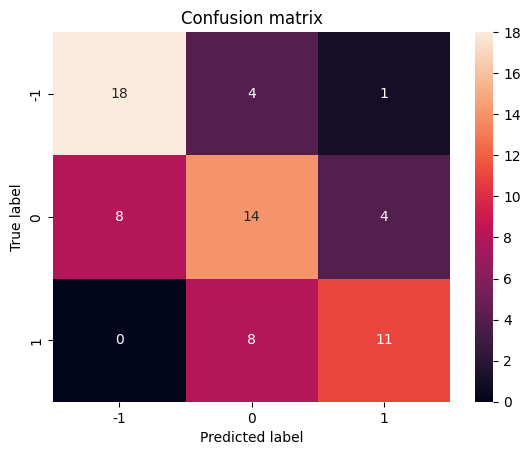

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322


In [5]:
metric, model = calc_metrics(
    tf_idf, y, 
    LogisticRegression, 
    name='tf_idf l1 only release', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

Слова при которых коэффициент равен нулю, будем считать стоп-словами. Сохраним их в `stopwords.txt`.

In [6]:
words = vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)]
with open('stopwords.txt', 'wt', encoding='utf-8') as file:
    file.writelines(s + '\n' for s in words)

In [7]:
STOP_WORDS |= set(vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)])

In [8]:
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf, y,
    LogisticRegression,
    name='tf-idf', 
    plot=False, 
    solver='saga', 
    penalty='elasticnet', 
    C=c, 
    max_iter=10000, 
    l1_ratio=l1_ratio
) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=30.0, l1_ratio=0.003981071705534973, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.9101977351405269


              precision    recall  f1-score   support

        -1.0       0.77      0.87      0.82        23
         0.0       0.71      0.65      0.68        26
         1.0       0.83      0.79      0.81        19

    accuracy                           0.76        68
   macro avg       0.77      0.77      0.77        68
weighted avg       0.76      0.76      0.76        68



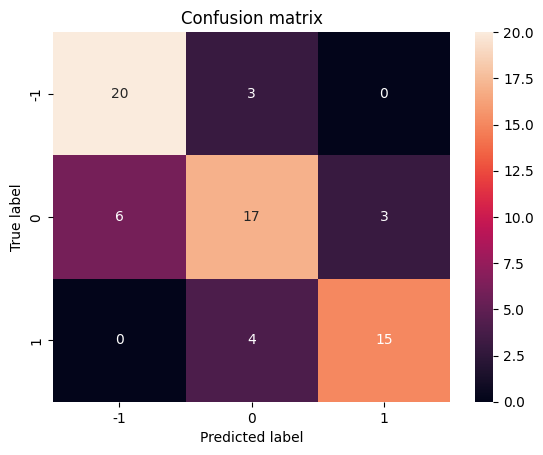

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142


In [10]:
metric, model = calc_metrics(
    tf_idf, y, 
    LogisticRegression, 
    name='tf_idf only release best word', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество еще немного подросло. Как и в случае с мешком слов попробуем обучить tf-idf на названиях и добавим эти переменые в матрицу объект-признак.

In [11]:
vectorizer_title = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

tf_idf_title = vectorizer_title.transform(X.title)

In [12]:
tf_idf_title_release = np.concatenate((tf_idf.toarray(), tf_idf_title.toarray()), axis=1)

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf_title_release, y,
    LogisticRegression,
    name='tf-idf', 
    plot=False, 
    solver='saga', 
    penalty='elasticnet', 
    C=c, 
    max_iter=10000, 
    l1_ratio=l1_ratio
) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=30.0, l1_ratio=0.015848931924611134, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.8989027753329814


              precision    recall  f1-score   support

        -1.0       0.82      0.78      0.80        23
         0.0       0.63      0.73      0.68        26
         1.0       0.81      0.68      0.74        19

    accuracy                           0.74        68
   macro avg       0.75      0.73      0.74        68
weighted avg       0.75      0.74      0.74        68



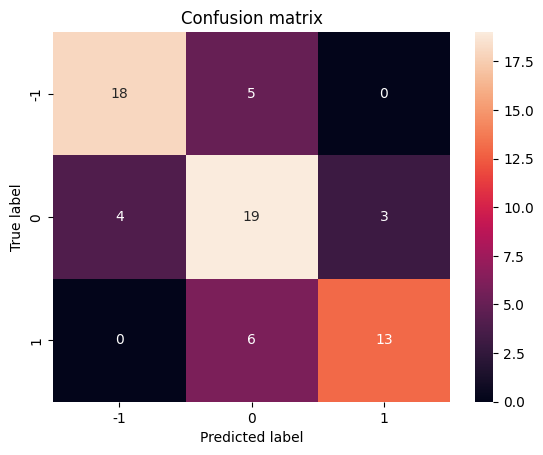

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903


In [14]:
metric, model = calc_metrics(
    tf_idf_title_release, y, 
    LogisticRegression, 
    name='tf_idf title release', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

При добавлении названия, качество модели заметно ухудшается, возможно эти признаки приводят к переобучению. Попробуем добавить количественные переменные.

In [15]:
tf_idf_num = np.concatenate((tf_idf.toarray(), X[num_columns].values), axis=1)

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf_num, y,
    LogisticRegression,
    name='tf-idf', 
    plot=False, 
    solver='saga', 
    penalty='elasticnet', 
    C=c, 
    max_iter=10000, 
    l1_ratio=l1_ratio
) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=30.0, l1_ratio=0.001, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8350349116939507


              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.61      0.73      0.67        26
         1.0       0.80      0.63      0.71        19

    accuracy                           0.69        68
   macro avg       0.71      0.69      0.69        68
weighted avg       0.70      0.69      0.69        68



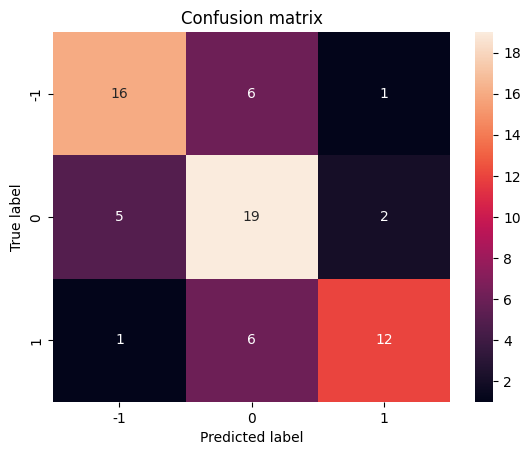

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [17]:
metric, model = calc_metrics(
    tf_idf_num, y,
    LogisticRegression,
    name='tf_idf numerical release', 
    **best_model.get_params()
)
metrics = pd.concat([metrics, metric], axis=0)
metrics

Добавление цифр из наших данных только ухудшило нашу модель. Попробуем обучить SVC, на tf-idf матрице лучших слов.

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf, y,
    SVC,
    name='bow svc only release', 
    kernel=kernel,
    C=c,
    plot=False, 
    probability=True,
) for c in np.logspace(-4, 3, 50) for kernel in ['linear', 'poly', 'rbf', 'sigmoid'])

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - SVC(C=37.27593720314938, kernel='linear', probability=True)
ROC-AUC = 0.9360587924661151


              precision    recall  f1-score   support

        -1.0       0.76      0.83      0.79        23
         0.0       0.73      0.73      0.73        26
         1.0       0.94      0.84      0.89        19

    accuracy                           0.79        68
   macro avg       0.81      0.80      0.80        68
weighted avg       0.80      0.79      0.80        68



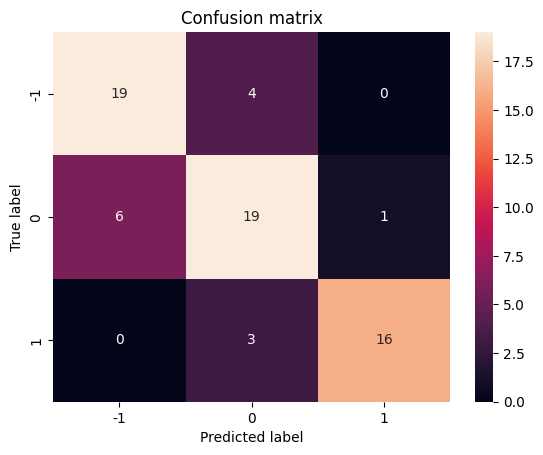

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [30]:
metric, _ = calc_metrics(
    tf_idf, y, 
    SVC, 
    name='tf-idf svc only release', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Мы еще немного улучшились.

In [31]:
metrics.to_csv('metrics.csv')